In [2]:
# ignore future warning
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# processing of text
from preprocessing import Preprocessing

# models
import torch
import xgboost
from model_functions import train_validation_test_split, split_train_val_test, Modeling, add_to_table_xgboost
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# inicjalize table for result
result = ''

In [3]:
data = Preprocessing()

In [4]:
data.load_data()
data.remove_quoting_comments()
data.demojize()
data.clean_text()
data.stopwords_remove()
data.lemmatize_text()
data.correct_typo_words()
data.token_join()
data.write_to_file()

# Model

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test()

In [15]:
# tfidf_vectorizer = TfidfVectorizer()

# # TF-IDF feature matrix
# X_train = tfidf_vectorizer.fit_transform(X_train)
# X_test = tfidf_vectorizer.transform(X_test)

In [17]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train.astype('U').values)
X_val = vectorizer.transform(X_val.astype('U').values)

In [18]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [19]:
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val, y_pred))

[[1812   76    2]
 [ 307  323    0]
 [   9    5    1]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1890
           1       0.80      0.51      0.62       630
           2       0.33      0.07      0.11        15

    accuracy                           0.84      2535
   macro avg       0.66      0.51      0.55      2535
weighted avg       0.84      0.84      0.83      2535

0.842603550295858


In [21]:
log_reg = Modeling(RandomForestClassifier(), 
                   X_train, X_val, y_train, y_val, result,
                   'Logistic Regression')
log_reg.fit_predict()
log_reg.print_results()
result = log_reg.add_to_table()

Results for Logistic Regression:
Logistic Regression accuracy: 0.8406
Logistic Regression f-score: 0.8256
Logistic Regression recall: 0.8406


C:\Users\kotul\anaconda3\envs\praca37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass normalize=weighted as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


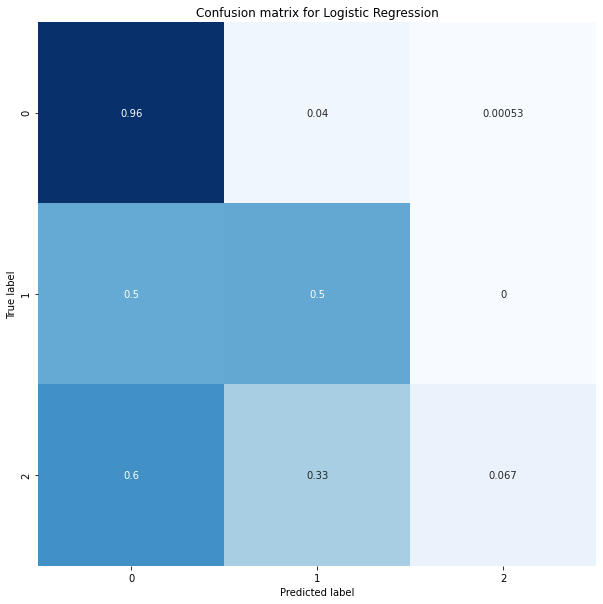

In [23]:
log_reg.plot_confusion_matrix_percent()

In [ ]:
# Logistic Regression

log_reg = Modeling(LogisticRegression(solver='saga'), 
                         X_train, X_val, y_train, y_val, result,
                         'Logistic Regression')
log_reg.fit_predict()
log_reg.print_results()
log_reg.plot_confusion_matrix()
result = log_reg.add_to_table()

C:\Users\kotul\anaconda3\envs\praca37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kotul\anaconda3\envs\praca37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass normalize=weighted as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Results for Logistic Regression SMOTE:
Logistic Regression SMOTE accuracy: 0.729
Logistic Regression SMOTE f-score: 0.7764
Logistic Regression SMOTE recall: 0.729


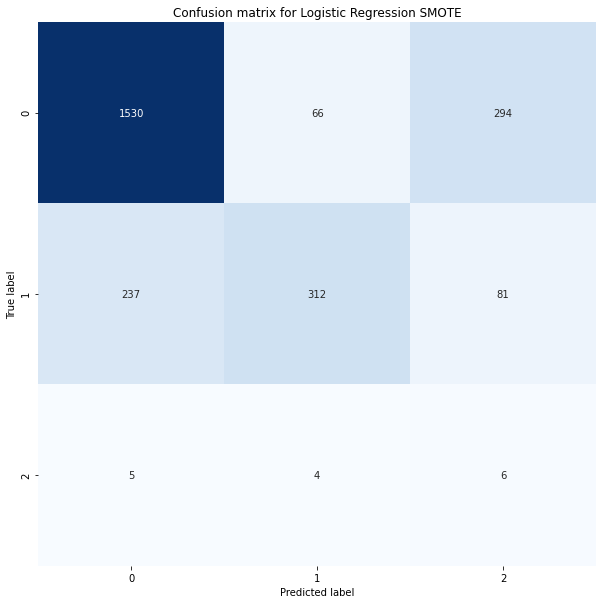

In [25]:
# SMOTE for Logistic Regression

log_reg_smote = Modeling(LogisticRegression(solver='saga'), 
                         X_train, X_val, y_train, y_val, result,
                         'Logistic Regression SMOTE')
log_reg_smote.sample(SMOTE(sampling_strategy='minority'))
log_reg_smote.fit_predict()
log_reg_smote.print_results()
log_reg_smote.plot_confusion_matrix()
result = log_reg_smote.add_to_table()

Results for SVC:
SVC accuracy: 0.826
SVC f-score: 0.7973
SVC recall: 0.826


C:\Users\kotul\anaconda3\envs\praca37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass normalize=weighted as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


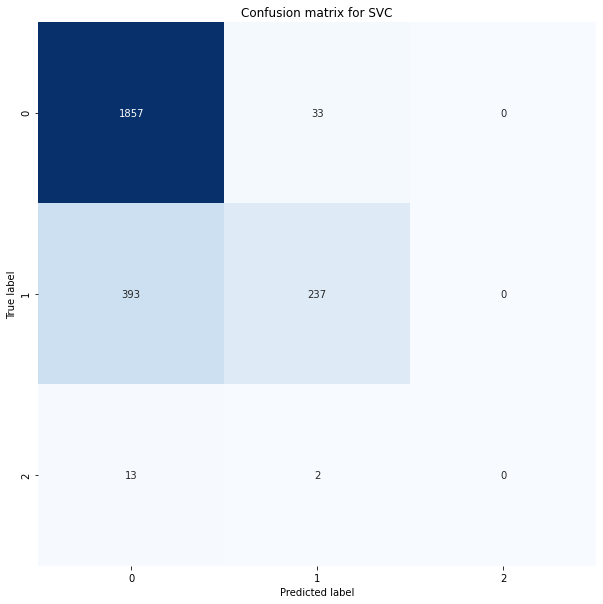

In [26]:
# SMOTE for Logistic Regression

svc = Modeling(SVC(probability=True), 
                          X_train, X_val, y_train, y_val, result,
                         'SVC')
svc.fit_predict()
svc.print_results()
svc.plot_confusion_matrix()
result = svc.add_to_table()

Results for SVC SMOTE:
SVC SMOTE accuracy: 0.789
SVC SMOTE f-score: 0.7413
SVC SMOTE recall: 0.789


C:\Users\kotul\anaconda3\envs\praca37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass normalize=weighted as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


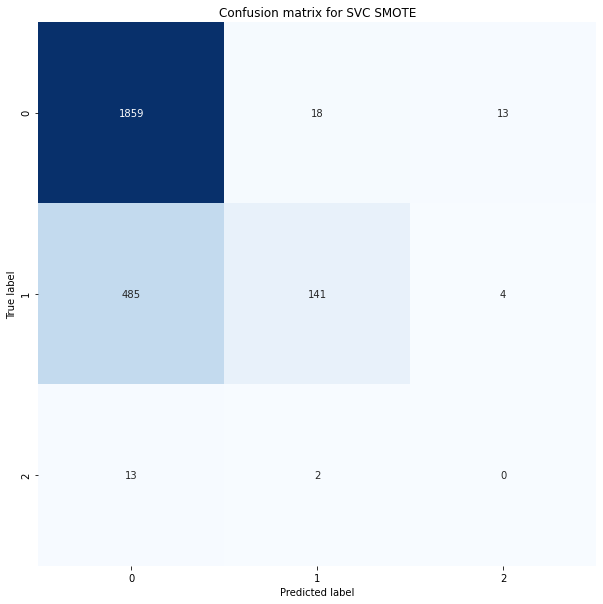

In [27]:
# SMOTE for Logistic Regression

svc_smote = Modeling(SVC(probability=True), 
                          X_train, X_val, y_train, y_val, result,
                         'SVC SMOTE')
svc_smote.sample(SMOTE(sampling_strategy='minority'))
svc_smote.fit_predict()
svc_smote.print_results()
svc_smote.plot_confusion_matrix()
result = svc_smote.add_to_table()

In [ ]:
bayes = Modeling(MultinomialNB(), 
                          X_train, X_val, y_train, y_val, result,
                         'Bayes')
bayes.fit_predict()
bayes.print_results()
bayes.plot_confusion_matrix()
result = bayes.add_to_table()

Results for Bayes:
Bayes accuracy: 0.8296
Bayes f-score: 0.8385
Bayes recall: 0.8296


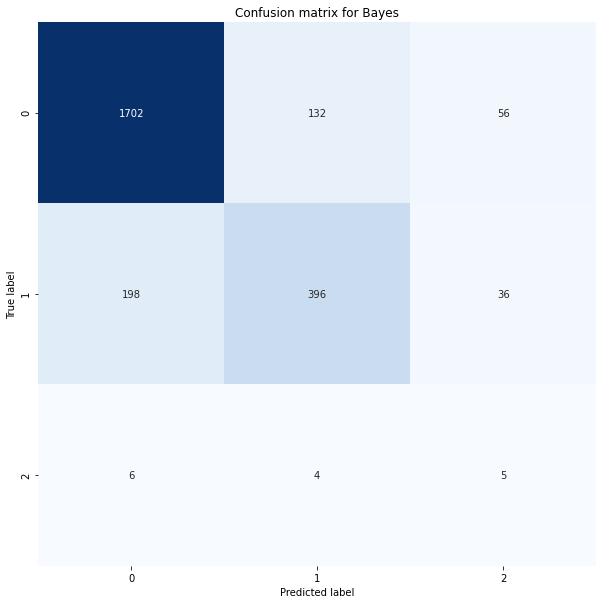

In [33]:
bayes_smote = Modeling(MultinomialNB(), 
                          X_train, X_val, y_train, y_val, result,
                         'Bayes SMOTE')
bayes_smote.sample(SMOTE(sampling_strategy='minority'))
bayes_smote.fit_predict()
bayes_smote.print_results()
bayes_smote.plot_confusion_matrix()
result = bayes_smote.add_to_table()

In [30]:
oversample = SMOTE()
X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)
train = xgboost.DMatrix(X_train_s, label=y_train_s)
val = xgboost.DMatrix(X_val, label=y_val)

In [31]:
param = {'max_depth':50, 'eta':0.5, 'objective': 'multi:softmax', 'num_class': 3}
epochs=100
bst = xgboost.train(param, train, epochs)
# make prediction
preds = bst.predict(val)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1890
           1       0.74      0.55      0.63       630
           2       0.25      0.07      0.11        15

    accuracy                           0.84      2535
   macro avg       0.62      0.52      0.54      2535
weighted avg       0.83      0.84      0.83      2535



In [67]:
result = add_to_table_xgboost(y_val, preds, result, 'XGboost')

In [69]:
result.transpose()

,Accuracy,F-score,Recall
Logistic Regression,0.8375,0.8225,0.8375
Logistic Regression,0.8406,0.8256,0.8406
Logistic Regression,0.8394,0.8246,0.8394
Logistic Regression SMOTE,0.7290,0.7764,0.7290
SVC,0.8260,0.7973,0.8260
SVC SMOTE,0.7890,0.7413,0.7890
Bayes,0.8296,0.8388,0.8296
Bayes,0.8296,0.8385,0.8296
XGboost,0.8359,0.8257,0.8359
